From tutorial: https://pytorch.org/tutorials/beginner/fgsm_tutorial.html

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from methods import *

# Choice of Model to Attack
- LeNet5: MNIST
- Basic CNN: Fashion MNIST
- ResNet20: CIFAR-10
### Run **ONE** of the following 3 cells

In [2]:
from models.LeNet import *
target_mdl = LeNet("models/lenet_mnist_model.pth")
model = target_mdl.model
device = target_mdl.device
test_loader = target_mdl.testloader

In [3]:
from models.simple_FashionMNIST import *
target_mdl = simple_FashionMNIST("models/simple_FashionMNIST.pth")
model = target_mdl.model
device = target_mdl.device
test_loader = target_mdl.testloader

Running on cpu.
Model weights loaded successfully


In [2]:
from models.resNet import ResNet20
target_mdl = ResNet20()
model = target_mdl.model
device = target_mdl.device
test_loader = target_mdl.testloader

Using cache found in C:\Users\JIC/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Files already downloaded and verified


# Get baseline

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


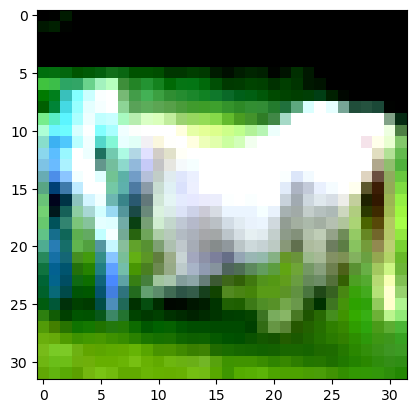

In [5]:
conf_mat = np.zeros((target_mdl.num_classes, target_mdl.num_classes))
i = 0
num_ex = 100
for image, target in target_mdl.testloader:
    #print(image.shape)
    #print(torch.min(image), torch.max(image))
    img = image.squeeze().numpy()
    outputs = model(image)
    _, predicted = torch.max(outputs.data, 1)#torch.argmax(outputs).item()
    #print(out_idx, target)
    conf_mat[predicted, target] += 1
    i +=1
    if i >= num_ex:
        break
plt.imshow(np.transpose(img/2 +0.5, (1, 2, 0)))

In [3]:
accuracies = []
examples = []
hist_dfs = []
final_hist_dfs = []
fw_iters = [15]
eps = 0.005
adv_examples = []
hist = None
debug = True
# Run test for each epsilon
algs = ['fw_away']
for alg in algs:
    acc, ex, hist = test_fw(target_mdl, device, eps, 15, method=alg, early_stopping='gap_FW', fw_stepsize_rule='decay', gap_FW_tol=0.1)
    accuracies.append(acc)
    examples.append(ex)
    hist_dfs.append(hist)
    final_hist = hist.groupby('example_idx').tail(1)
    final_hist_dfs.append(final_hist) # hist with just the rows of last FW iters
final_hist_dfs[-1]

Epsilon: 0.005	Correct Classifications (Failed Attacks) = 47 / 1000 = 0.047


,example_idx,FW_iter,gap_FW,success,first_success,target,pred,stop_cond,gap_AS,step_type,max_step,stepsize,alphas,diff,drop_step,min_revisit_diff
1,0,2,4.201375e-05,True,False,3,5,gap,1.027736e-07,FW,1,0.666667,"[0.33333333333333337, 0.6666666666666666]",0.013333,NaN,13.009993
3,1,2,8.486261e-07,True,False,8,9,gap,8.069509e-14,FW,1,0.666667,"[0.33333333333333337, 0.6666666666666666]",0.013333,NaN,12.269990
6,2,3,1.816840e-02,True,False,8,0,gap,5.209552e-03,FW,1,0.500000,"[0.16666666666666669, 0.3333333333333333, 0.5]",0.010000,NaN,8.449991
8,3,2,4.230366e-03,True,False,3,5,gap,4.736306e-10,FW,1,0.666667,"[0.33333333333333337, 0.6666666666666666]",0.013333,NaN,12.179990
23,4,15,8.896650e-02,True,False,1,9,gap,4.629412e-02,FW,1,0.125000,"[0.008333333333333337, 0.01666666666666667, 0....",0.002500,NaN,3.019998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4088,995,2,9.880333e-03,True,False,3,5,gap,8.807247e-12,FW,1,0.666667,"[0.33333333333333337, 0.6666666666666666]",0.013333,NaN,11.779989
4103,996,15,2.574506e-01,True,True,7,2,max_iter,1.424289e-01,FW,1,0.125000,"[0.008333333333333337, 0.01666666666666667, 0....",0.002500,NaN,2.899997
4105,997,2,9.930397e-05,True,False,4,3,gap,6.737846e-12,FW,1,0.666667,"[0.33333333333333337, 0.6666666666666666]",0.013333,NaN,15.109992
4107,998,2,5.892874e-03,True,False,1,0,gap,9.731574e-11,FW,1,0.666667,"[0.33333333333333337, 0.6666666666666666]",0.013333,NaN,15.049988


In [4]:
hist[hist['gap_FW'] < hist['gap_FW']]

,example_idx,FW_iter,gap_FW,success,first_success,target,pred,stop_cond,gap_AS,step_type,max_step,stepsize,alphas,diff,drop_step,min_revisit_diff


In [ ]:
final_hist = final_hist_dfs[-1]

In [11]:
hist.groupby('step_type').size()

step_type
FW    4110
dtype: int64

<Axes: xlabel='FW_iter'>

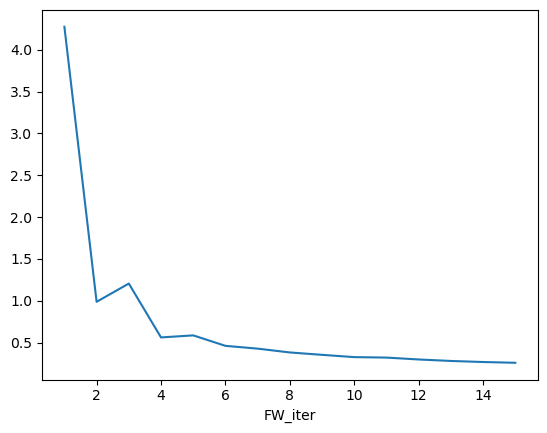

In [6]:
hist.groupby('FW_iter')['gap_FW'].mean().plot()

In [ ]:
hist[hist['step']=='AS'].groupby('S_idx').size()

S_idx
1    555
2     35
3     57
4     19
5     11
6      7
7      3
8      1
dtype: int64

In [8]:
final_hist.groupby('stop_cond').size()

stop_cond
gap         852
max_iter     75
dtype: int64

In [ ]:
final_hist.groupby('success')['gap_FW'].mean()

success
False    0.358653
True     0.012330
Name: gap_FW, dtype: float64

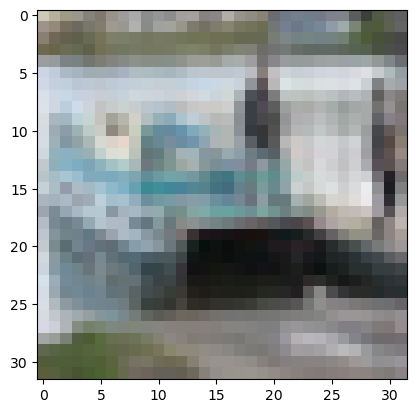

In [ ]:
plt.imshow(np.transpose(ex[3][2], (1, 2, 0)))

<Axes: xlabel='FW_iter'>

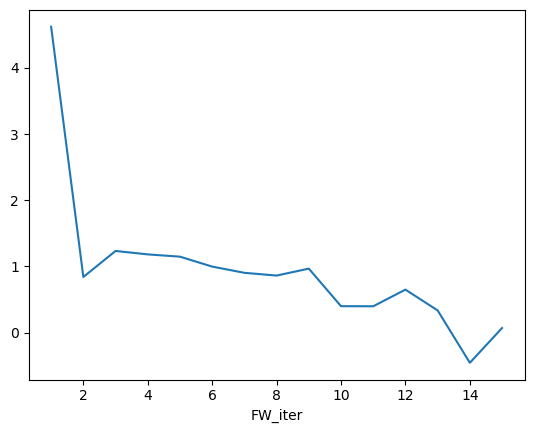

In [ ]:
hist[hist['example_idx'].isin(final_hist[(final_hist['success'] == True) & (final_hist['stop_cond'] == 'gap')]['example_idx'])].groupby('FW_iter')['gap_FW'].mean().plot()

Mean FW iterations: 4.433656957928803


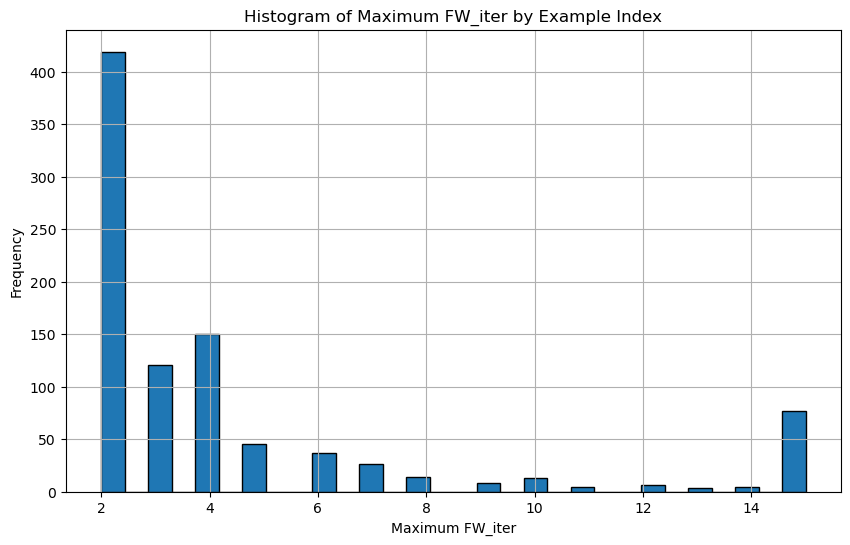

In [13]:
num_iters = hist.groupby('example_idx')['FW_iter'].max()
print(f"Mean FW iterations: {num_iters.mean()}")
plt.figure(figsize=(10, 6))
num_iters.plot(kind='hist', bins=30, edgecolor='black')
plt.title('Histogram of Maximum FW_iter by Example Index')
plt.xlabel('Maximum FW_iter')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
# accuracy
hist.groupby('example_idx')['first_success'].sum().mean()

0.7784946236559139

In [ ]:
# average number of iterations for success
hist[hist['first_success']]['FW_iter'].mean()

1.4820441988950277

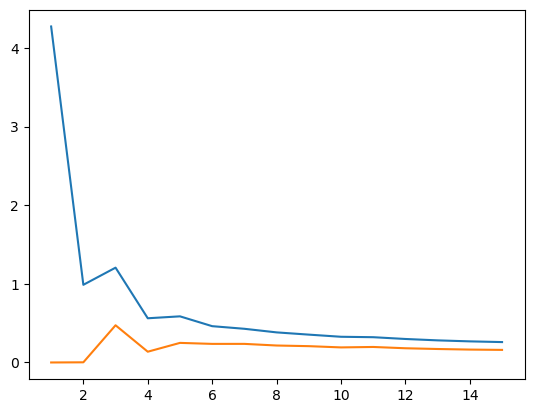

In [7]:
plt.plot(hist.groupby('FW_iter')['gap_FW'].mean())
plt.plot(hist.groupby('FW_iter')['gap_AS'].mean())

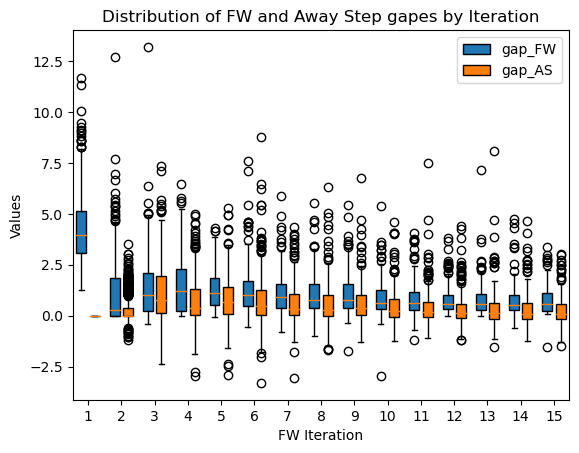

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Sample data generation for demonstration purposes

# Extracting unique iteration groups
groups = hist['FW_iter'].unique()

# Creating lists to hold data for each group
data_FW = []
data_AS = []

for group in groups:
    data_FW.append(hist[hist['FW_iter'] == group]['gap_FW'].values)
    data_AS.append(hist[hist['FW_iter'] == group]['gap_AS'].values)

# Plotting
fig, ax = plt.subplots()

# Positions of the boxplots
positions_FW = np.arange(1, len(groups) + 1) * 2.0 - 0.4
positions_AS = np.arange(1, len(groups) + 1) * 2.0 + 0.4

# Creating the boxplots
box_FW = ax.boxplot(data_FW, positions=positions_FW, widths=0.6, patch_artist=True, boxprops=dict(facecolor="C0"))
box_AS = ax.boxplot(data_AS, positions=positions_AS, widths=0.6, patch_artist=True, boxprops=dict(facecolor="C1"))

# Customizing the plot
ax.set_xlabel('FW Iteration')
ax.set_ylabel('Values')
ax.set_title('Distribution of FW and Away Step gapes by Iteration')
ax.set_xticks(np.arange(1, len(groups) + 1) * 2.0)
ax.set_xticklabels([i for i in groups])

# Adding legend
ax.legend([box_FW["boxes"][0], box_AS["boxes"][0]], ['gap_FW', 'gap_AS'], loc='upper right')

# Display the plot
plt.show()


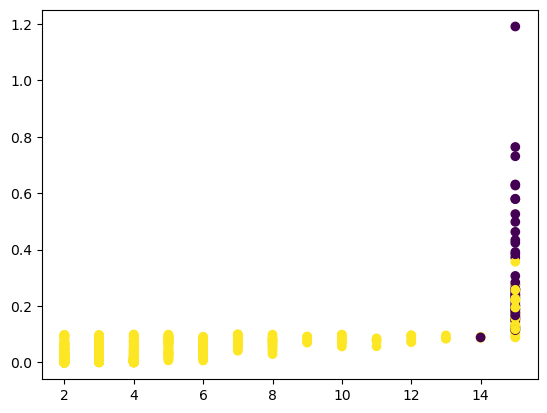

In [15]:
plt.scatter(final_hist['FW_iter'],final_hist['gap_FW'], c=final_hist['success'])

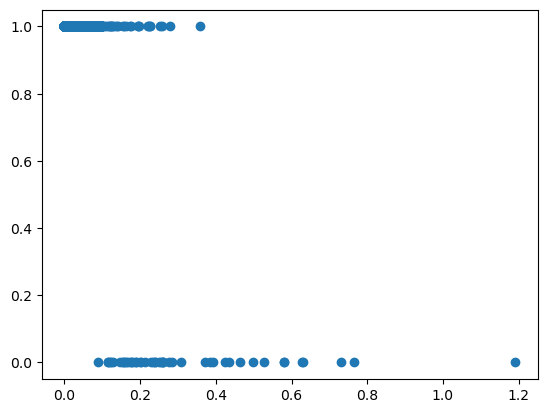

In [16]:
plt.scatter(final_hist['gap_FW'], final_hist['success'])

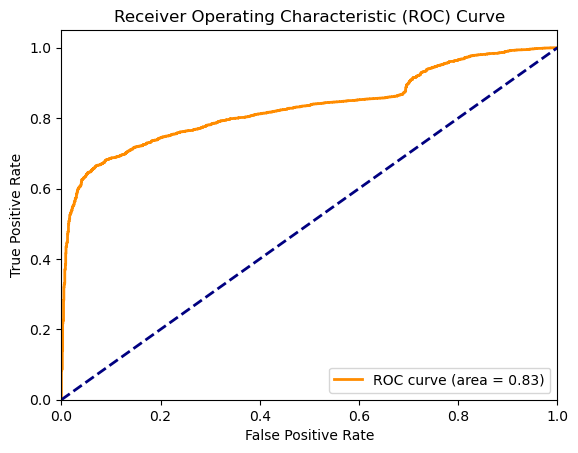

In [ ]:
from sklearn.metrics import roc_curve, auc

# Sample data: true binary labels and predicted probabilities
y_true = hist['success']
y_scores = 1- hist['gap_trans']

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

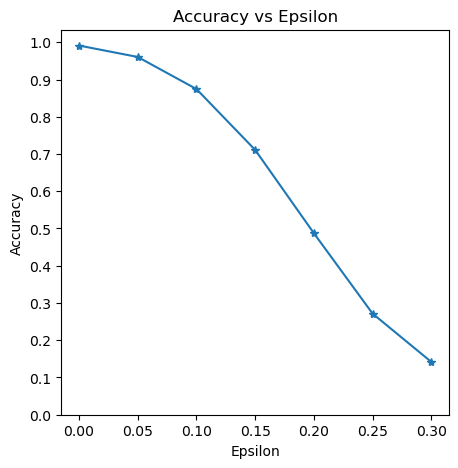

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

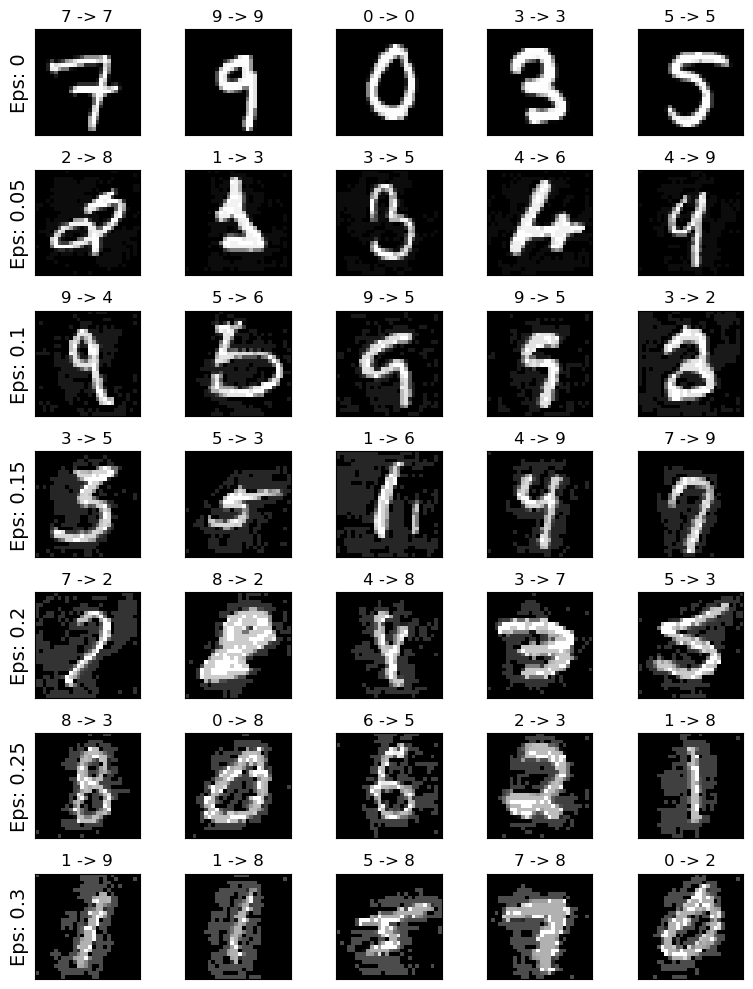

In [ ]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel(f"Eps: {epsilons[i]}", fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title(f"{orig} -> {adv}")
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()